In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import files

# Compute Energy Functions

In [2]:
def compute_energy(img):
    """Compute energy using explicit finite differences for gradient calculation."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64)

    # Compute ∂I/∂x using central difference: I(x+1, y) - I(x-1, y)
    dx = np.abs(gray[:, 2:] - gray[:, :-2])  # Shift left & right
    dx = np.pad(dx, ((0, 0), (1, 1)), mode='edge')  # Pad to maintain original size

    # Compute ∂I/∂y using central difference: I(x, y+1) - I(x, y-1)
    dy = np.abs(gray[2:, :] - gray[:-2, :])  # Shift up & down
    dy = np.pad(dy, ((1, 1), (0, 0)), mode='edge')  # Pad to maintain original size

    return dx + dy

# Find the Lowest Energy Vertical Seam

In [3]:
def find_vertical_seam(energy):
    rows, cols = energy.shape
    M = energy.copy().astype(np.float64) # M is the cumulative energy matrix
    backtrack = np.zeros_like(M, dtype=int)

    for i in range(1, rows): # Start from the second row (The first remains the same it is starting point)
        for j in range(cols):
            if j == 0: # leftmost pixels
                min_prev = min(M[i-1, j], M[i-1, j+1])
                min_idx = j if M[i-1, j] < M[i-1, j+1] else j+1
            elif j == cols - 1: # rightmost pixels
                min_prev = min(M[i-1, j-1], M[i-1, j])
                min_idx = j-1 if M[i-1, j-1] < M[i-1, j] else j
            else: # middle pixels
                min_prev = min(M[i-1, j-1], M[i-1, j], M[i-1, j+1])
                if M[i-1, j-1] == min_prev:
                    min_idx = j-1
                elif M[i-1, j] == min_prev:
                    min_idx = j
                else:
                    min_idx = j+1
            M[i, j] += min_prev # Update the cumulative energy
            backtrack[i, j] = min_idx

    seam = [np.argmin(M[-1])]
    for i in range(rows-1, 0, -1):
        seam.append(backtrack[i, seam[-1]])
    return np.array(seam[::-1])

# Remove The Seam

In [4]:
def remove_seam(img, seam):
    rows, cols = img.shape[:2]
    return np.array([np.delete(img[row], seam[row], axis=0) for row in range(rows)])

# Resize The Image (Vertical & Horizontal)

Saving Seam_PhotoTest.jpeg to Seam_PhotoTest (5).jpeg
Enter width resize percentage: 80
Enter height resize percentage: 80
Final Resized Image:


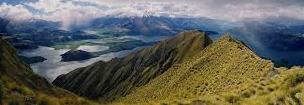

Vertical Seams Visualization:


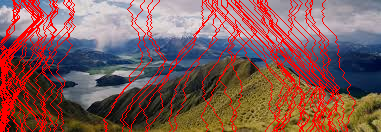

Horizontal Seams Visualization:


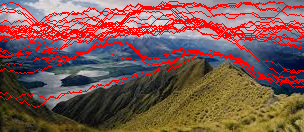

In [12]:
def seam_carving(input_path, resize_width_percent, resize_height_percent):
    img = cv2.imread(input_path)
    original = img.copy()

    # Separate visualizations
    vertical_visualization = original.copy()
    horizontal_visualization = None  # Will be created after vertical seams are removed

    rows, cols, _ = img.shape

    # Vertical seam removal (for width reduction)
    if resize_width_percent < 100:
        target_cols = int(cols * (resize_width_percent / 100))
        for _ in range(cols - target_cols):
            energy = compute_energy(img)
            seam = find_vertical_seam(energy)
            for row in range(rows):
                vertical_visualization[row, seam[row]] = [0, 0, 255]  # Mark seam in red
            img = remove_seam(img, seam)
        cols = img.shape[1]  # Update new width

    # Save vertical seam visualization
    cv2.imwrite("vertical_seams.jpg", vertical_visualization)

    # Create a new visualization after vertical resizing
    horizontal_visualization = img.copy()

    # Horizontal seam removal (for height reduction)
    if resize_height_percent < 100:
        img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        horizontal_visualization = cv2.rotate(horizontal_visualization, cv2.ROTATE_90_CLOCKWISE)
        target_height = int(rows * (resize_height_percent / 100))

        for _ in range(rows - target_height):
            energy = compute_energy(img)
            seam = find_vertical_seam(energy)
            for row in range(img.shape[0]):
                horizontal_visualization[row, seam[row]] = [0, 0, 255]  # Mark seam in red
            img = remove_seam(img, seam)

        # Rotate images back to original orientation
        img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
        horizontal_visualization = cv2.rotate(horizontal_visualization, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # Save horizontal seam visualization
    cv2.imwrite("horizontal_seams.jpg", horizontal_visualization)

    # Save final resized image
    cv2.imwrite("resized_image.jpg", img)

    # Show results
    print("Final Resized Image:")
    cv2_imshow(img)
    print("Vertical Seams Visualization:")
    cv2_imshow(vertical_visualization)
    print("Horizontal Seams Visualization:")
    cv2_imshow(horizontal_visualization)
if __name__ == '__main__':
    uploaded = files.upload()
    input_path = list(uploaded.keys())[0]

    resize_width_percent = float(input("Enter width resize percentage: "))
    resize_height_percent = float(input("Enter height resize percentage: "))

    if resize_width_percent <= 0 or resize_width_percent > 100:
        raise ValueError("Width reduction percentage must be between 0 and 100.")
    if resize_height_percent <= 0 or resize_height_percent > 100:
        raise ValueError("Height reduction percentage must be between 0 and 100.")

    seam_carving(input_path, resize_width_percent, resize_height_percent)